<a href="https://colab.research.google.com/github/Fr2zyRoom/AIMC_MSK-2/blob/main/MURA_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MURA-musculoskeletal radiographs

## Opening
실습에 앞서 필요한 데이터와 라이브러리를 내려받습니다.  
[런타임]-[런타임 유형 변경]에서 하드웨어 가속기를 GPU로 변경합니다.  
라이브러리를 모두 받은 후에 꼭 [런타임]-[런타임 다시 시작]을 눌러주세요.  

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17f02jL3m6Yq14v5jYUrXRoE9w3K8Kbv0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17f02jL3m6Yq14v5jYUrXRoE9w3K8Kbv0" -O MURA_refined_data_df.csv && rm -rf ~/cookies.txt

In [ ]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F8NS2Wmy0dkTqrmRGtqYlC-kfUtm7YI4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1F8NS2Wmy0dkTqrmRGtqYlC-kfUtm7YI4" -O MURA-v1.1_refined.zip && rm -rf ~/cookies.txt

In [ ]:
!unzip MURA-v1.1_refined.zip -d ./MURA-v1.1_refined

In [ ]:
!pip install --force-reinstall albumentations==1.0.3

In [ ]:
!pip install timm

In [ ]:
!pip uninstall opencv-python -y

In [ ]:
!pip install opencv-python

In [ ]:
!pip install grad-cam

## Build pytorch custom dataset

In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm

import os
import time
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

In [3]:
total_datainfo_df = pd.read_csv('MURA_refined_data_df.csv')

In [4]:
dataroot = 'MURA-v1.1_refined'

In [5]:
def match_data_and_label(dataroot, 
                         label_df):
    """match data(dataroot) and labels(DataFrame)
    Parameters:
        dataroot (str) -- directory to data
        label_df (DataFrame) -- label_dataframe
        label_col (str) -- label column in the label DataFrame 
        
    Return:
        data_label_ls (list) -- a list of data_path and labels(matched)
    """
    data_label_ls=[]
    for patient, study, label in label_df[['Patient','Study','Abnormality']].values:
        datadir = os.path.join(dataroot,patient,study)
        filepath_ls = sorted([os.path.join(datadir,f) for f in os.listdir(datadir) if not f.startswith('.')])
        for filepath in filepath_ls:
            #check dir
            if os.path.exists(filepath):
                data_label_ls.append([filepath,label])
    
    return data_label_ls


def gen_dataset_ls(dataroot, 
                   label_csv_path, 
                   split=None):
    """match data(dataroot) and labels(label_csv)
    Parameters:
        dataroot (str) -- directory to data
        label_csv_path (str) -- a path of csv file
        split (str) --
        
    Return:
        data_label_ls (list) -- a list of data_path and labels(matched)
    """
    label_df = pd.read_csv(label_csv_path)
    if split:
        label_df = label_df[label_df.Dataset == split]
    data_label_ls = match_data_and_label(dataroot, 
                                         label_df)
    return data_label_ls

In [6]:
def img_loader(img_path):
    tmp = np.array(Image.open(img_path))
    #gamma correction
    #tmp = exposure.adjust_gamma(tmp, .7)
    return np.stack([tmp]*3,-1)


def get_transform(params=None, mode=None, resize_factor=256, gray_scale=False, convert=True):
    transform_list = []
    #padding
    transform_list.append(
        A.augmentations.geometric.resize.LongestMaxSize(max_size=resize_factor)
    )
    transform_list.append(
        A.augmentations.transforms.PadIfNeeded(min_height=resize_factor, 
                                               min_width=resize_factor, 
                                               border_mode=cv2.BORDER_CONSTANT, 
                                               value=0)
    )
    if mode=='Train':
        ## geometric transform
        transform_list.append(
            A.ShiftScaleRotate(shift_limit=0.03, 
                               scale_limit=0.1, 
                               rotate_limit=10, 
                               p=0.4, 
                               border_mode = cv2.BORDER_CONSTANT)
        )
        ## brightness or contrast
        transform_list.append(
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.1, 
                                           contrast_limit=0.1),
                A.RandomGamma(p=1)
            ], p=.3)
        )
        ## blur or sharpen
        transform_list.append(
            A.OneOf([
                A.GaussianBlur(sigma_limit=(0,0.1)),
                A.Sharpen(alpha=(0., 0.1))
            ], p=.2)
        )
    ## normalize
    if convert:
        if gray_scale:
            transform_list.append(
                A.Normalize(mean=[0.5,],
                            std=[0.5,],)
            )
        else:
            transform_list.append(
                A.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],)
            )
        transform_list.append(ToTensorV2())
    
    return A.Compose(transform_list)


class MURADataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data_dir, 
                 csv_path, 
                 img_loader=img_loader,
                 resize_factor=256,
                 gray_scale=False,
                 transform=get_transform,
                 mode=None, 
                 convert=True):
        self.data_dir = data_dir
        self.csv_path = csv_path
        self.img_loader = img_loader
        self.mode = mode
        
        self.transform = transform(mode=self.mode, 
                                   gray_scale=gray_scale,
                                   convert=convert)
        
        data_label_ls = gen_dataset_ls(dataroot=self.data_dir, 
                                       label_csv_path=self.csv_path, 
                                       split=self.mode)
        
        self.data_path, self.labels = list(zip(*data_label_ls))
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, index):
        data = self.img_loader(self.data_path[index])
        if self.transform:
            data = self.transform(image=data)['image']
        #label = np.array(self.labels[index]).astype(float)
        
        return data, self.labels[index] #torch.FloatTensor(label)

In [7]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.axis("off")
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [80]:
aug_dataset = MURADataset(
    data_dir=dataroot,
    csv_path='MURA_refined_data_df.csv', 
    resize_factor=256,
    gray_scale=False,
    transform=get_transform,
    mode='Train', 
    convert=False
)

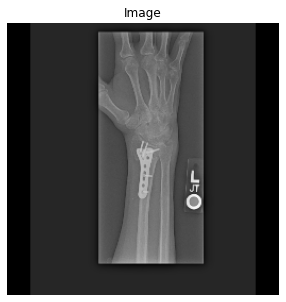

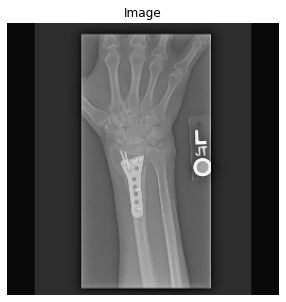

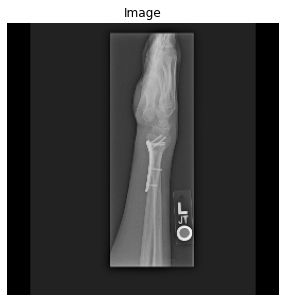

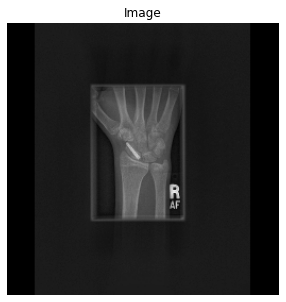

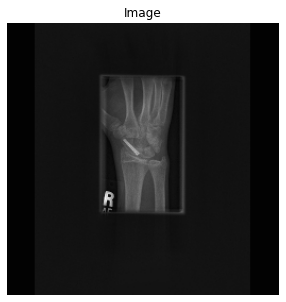

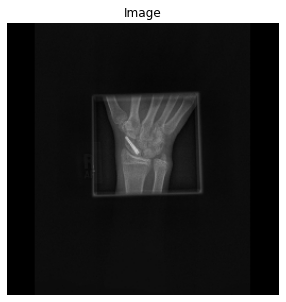

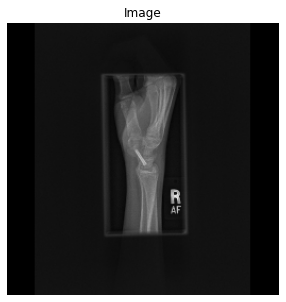

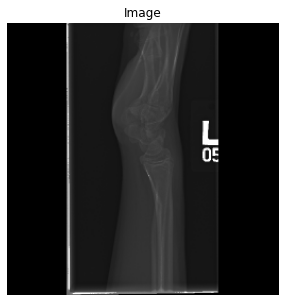

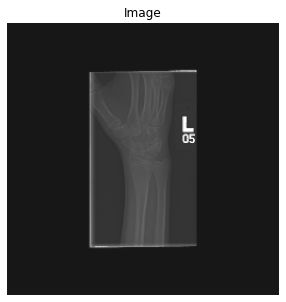

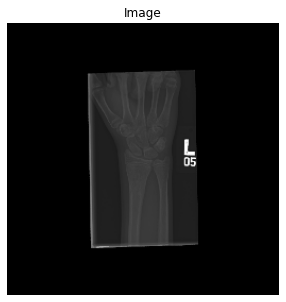

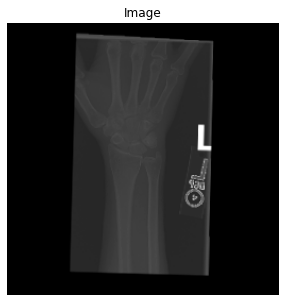

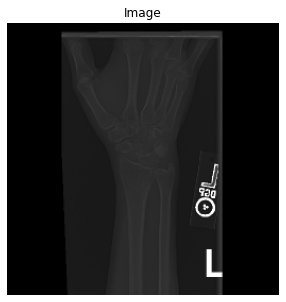

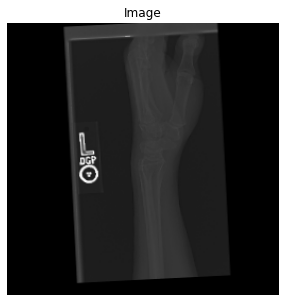

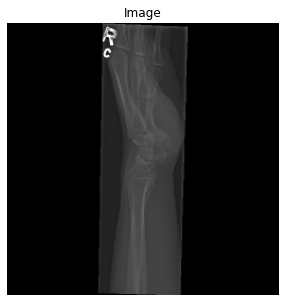

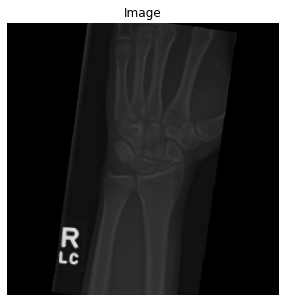

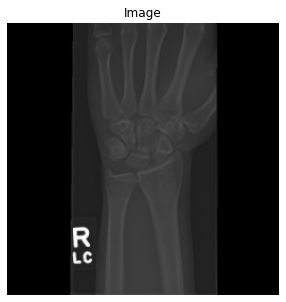

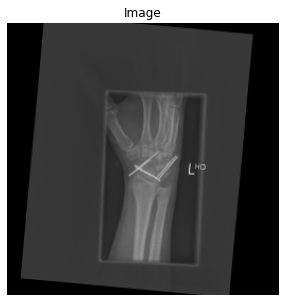

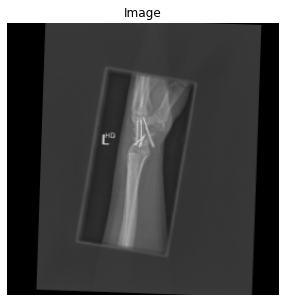

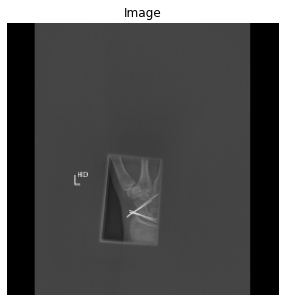

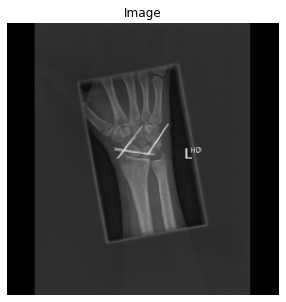

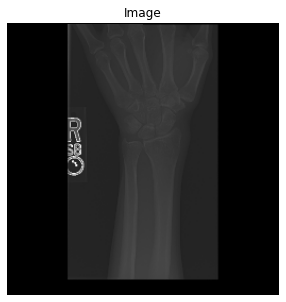

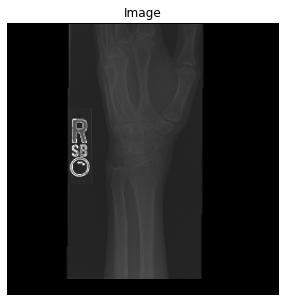

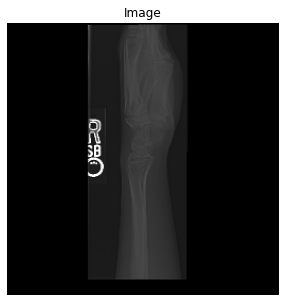

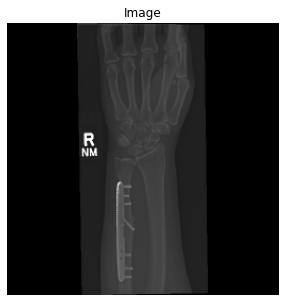

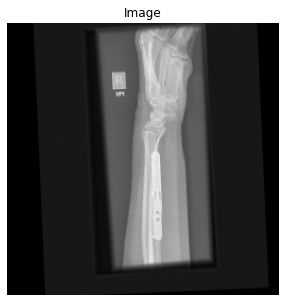

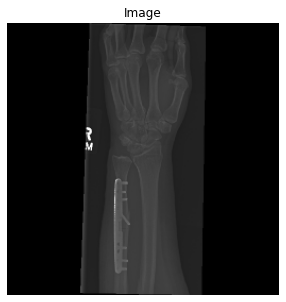

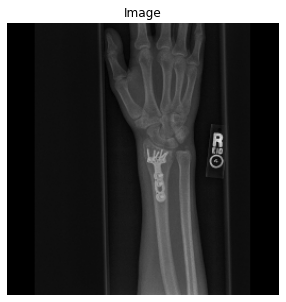

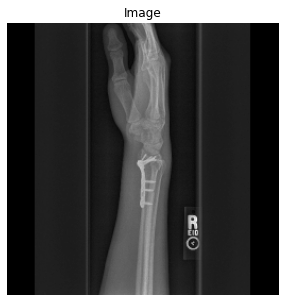

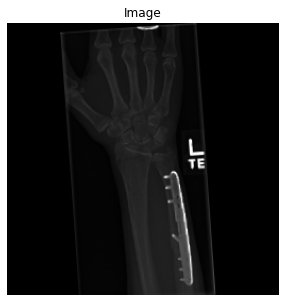

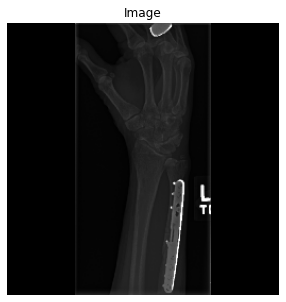

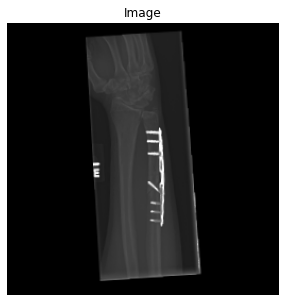

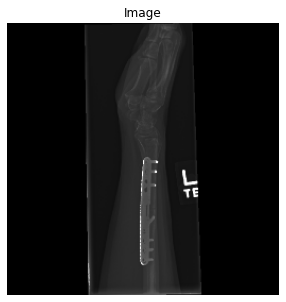

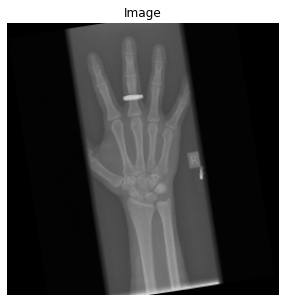

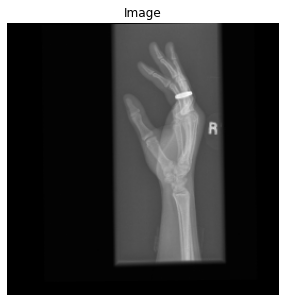

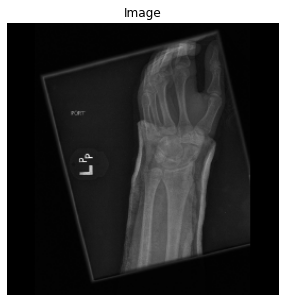

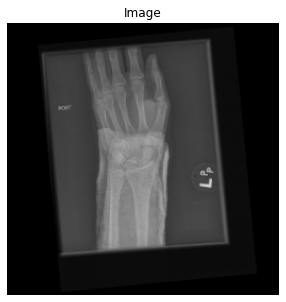

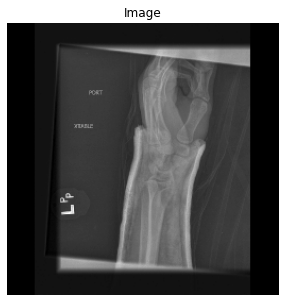

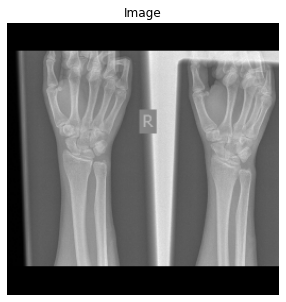

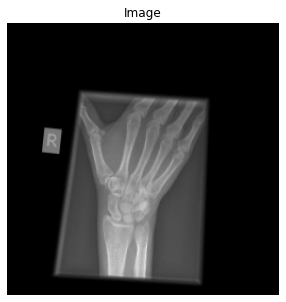

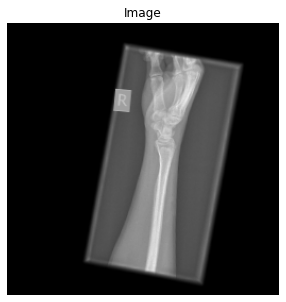

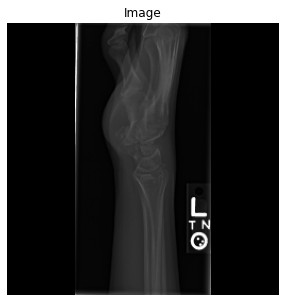

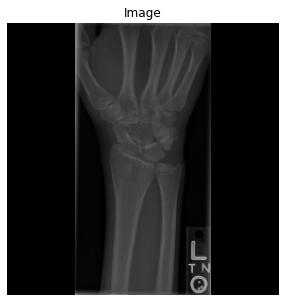

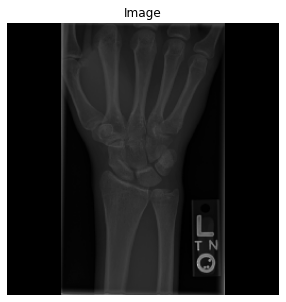

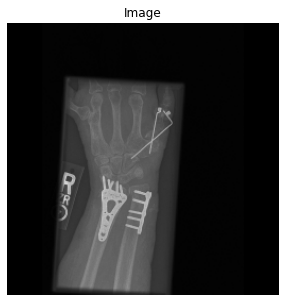

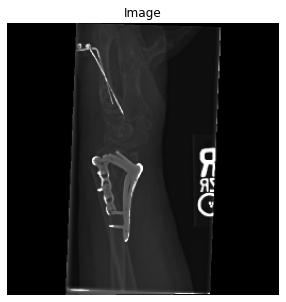

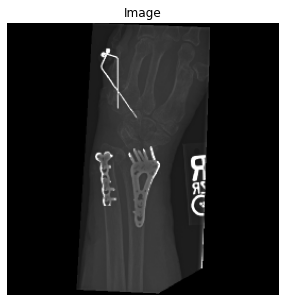

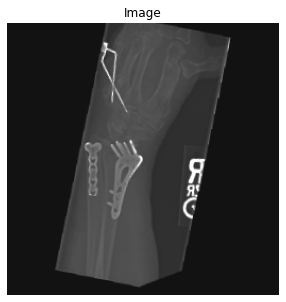

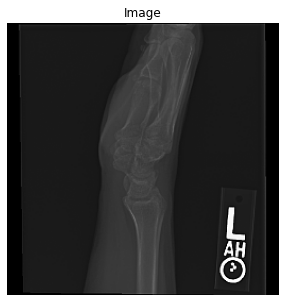

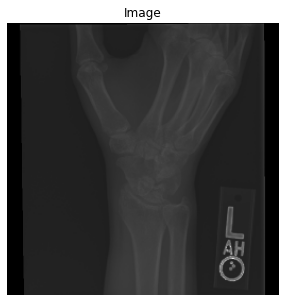

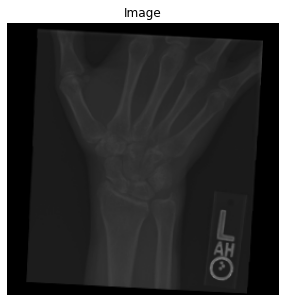

In [54]:
# check augmentation 
for i in range(0,50):
    image, label = aug_dataset[i] 
    visualize(image=image)

## Train model

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class AverageMeter(object):
    """
    Computes and stores the average and current value
    Copied from: https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_epoch(model, loader, optimizer, criterion, epoch, n_epochs, print_freq=3):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()

    # Model on train mode
    model.cuda()
    model.train()

    end = time.time()
    for batch_idx, (input, target) in enumerate(loader):
        # Create vaiables
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        batch_size = target.size(0)
        _, pred = output.data.cpu().topk(1, dim=1)
        error.update(torch.ne(pred.squeeze(), target.cpu()).float().sum().item() / batch_size, batch_size)
        losses.update(loss.item(), batch_size)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print stats
        if batch_idx % print_freq == 0:
            res = '\t'.join([
                'Epoch: [%d/%d]' % (epoch + 1, n_epochs),
                'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                'Error %.4f (%.4f)' % (error.val, error.avg),
            ])
            print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg


def test_epoch(model, loader, criterion, print_freq=2, is_test=True):
    batch_time = AverageMeter()
    losses = AverageMeter()
    error = AverageMeter()

    # Model on eval mode
    model.cuda()
    model.eval()

    end = time.time()
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            # Create vaiables
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            batch_size = target.size(0)
            _, pred = output.data.cpu().topk(1, dim=1)
            error.update(torch.ne(pred.squeeze(), target.cpu()).float().sum().item() / batch_size, batch_size)
            losses.update(loss.item(), batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # print stats
            if batch_idx % print_freq == 0:
                res = '\t'.join([
                    'Test' if is_test else 'Valid',
                    'Iter: [%d/%d]' % (batch_idx + 1, len(loader)),
                    'Time %.3f (%.3f)' % (batch_time.val, batch_time.avg),
                    'Loss %.4f (%.4f)' % (losses.val, losses.avg),
                    'Error %.4f (%.4f)' % (error.val, error.avg),
                ])
                print(res)

    # Return summary statistics
    return batch_time.avg, losses.avg, error.avg


def train(model, criterion, train_set, valid_set, test_set, save, n_epochs=300,
          batch_size=64, lr=0.0001, patience=10, save_epoch=10, seed=None, 
          train_print_freq=100, test_print_freq=10):
    cnt=0
    if seed is not None:
        torch.manual_seed(seed)

    # Data loaders
    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size, drop_last=True, shuffle=True, #sampler=ImbalancedDatasetSampler(train_set),
                                               pin_memory=(torch.cuda.is_available()), num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    if valid_set is None:
        valid_loader = None
    else:
        valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False,
                                                   pin_memory=(torch.cuda.is_available()), num_workers=0)
    # Model on cuda
    if torch.cuda.is_available():
        model = model.cuda()

    # Wrap model for multi-GPUs, if necessary
    model_wrapper = model
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model_wrapper = torch.nn.DataParallel(model).cuda()

    # Optimizer
    optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0.5 * n_epochs, 0.75 * n_epochs],
                                                     gamma=0.1)

    # Start log
    with open(os.path.join(save, 'results.csv'), 'w') as f:
        f.write('epoch,train_loss,train_error,valid_loss,valid_error,test_error\n')

    # Train model
    best_error = 1
    best_loss = 5
    for epoch in range(n_epochs):
        _, train_loss, train_error = train_epoch(
            model=model_wrapper,
            loader=train_loader,
            optimizer=optimizer, 
            criterion=criterion,
            epoch=epoch,
            n_epochs=n_epochs, 
            print_freq=train_print_freq
        )
        scheduler.step()
        _, valid_loss, valid_error = test_epoch(
            model=model_wrapper,
            loader=valid_loader if valid_loader else test_loader,
            criterion=criterion,
            print_freq=test_print_freq,
            is_test=(not valid_loader)
        )

        # Determine if model is the best
        if valid_loader:
            if valid_error < best_error:
                best_error = valid_error
                print('New best error: %.4f' % best_error)
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))
                torch.save(model.state_dict(), os.path.join(save, 'model_err_best.dat'))
            if valid_loss < best_loss:
                best_loss = valid_loss
                print('New best loss: %.4f' % best_loss)
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))
                torch.save(model.state_dict(), os.path.join(save, 'model_los_best.dat'))
        else:
            if (cnt%save_epoch==0):
                torch.save(model.state_dict(), os.path.join(save, 'model_epoch'+str(cnt).zfill(3)+'.dat'))

        # Log results
        with open(os.path.join(save, 'results.csv'), 'a') as f:
            f.write('%03d,%0.6f,%0.6f,%0.5f,%0.5f,\n' % (
                (epoch + 1),
                train_loss,
                train_error,
                valid_loss,
                valid_error,
            ))
        cnt+=1
        
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    torch.save(model.state_dict(), os.path.join(save, 'model_final.dat'))

    # Final test of model on test set
    model.load_state_dict(torch.load(os.path.join(save, 'model_final.dat')))
    if torch.cuda.is_available() and torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model).cuda()
    test_results = test_epoch(
        model=model,
        loader=test_loader,
        criterion=criterion,
        is_test=True
    )
    _, _, test_error = test_results
    with open(os.path.join(save, 'results.csv'), 'a') as f:
        f.write(',,,,,%0.5f\n' % (test_error))
    print('Final test error: %.4f' % test_error)

In [9]:
###################OPTION###################
dataroot='MURA-v1.1_refined'
csvpath='MURA_refined_data_df.csv'
savepoint='ckpt'
name='trial01'
##data##
resize_factor=256
gray_scale=False
##optimize##
batch_size=16
n_epochs=300
lr=0.0001
patience=10
train_print_freq=100
test_print_freq=10
############################################

In [12]:
save=os.path.join(savepoint, name)

In [ ]:
# Datasets
train_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Train', 
    convert=True
)
val_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Valid', 
    convert=True
)
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath, 
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)
# Models(ResNet)

model = timm.create_model('resnet152d', pretrained=True)
if gray_scale:
    model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.fc = torch.nn.Linear(model.fc.in_features, out_features=2, bias=True)


#print(model)


# Print number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", num_params)

# Make save directory
if not os.path.exists(save):
    os.makedirs(save)
if not os.path.isdir(save):
    raise Exception('%s is not a dir' % save)

# Train the model
train(model=model, 
      criterion=torch.nn.functional.cross_entropy,
      train_set=train_dataset, 
      valid_set=val_dataset, 
      test_set=test_dataset, 
      save=save,
      n_epochs=n_epochs, 
      batch_size=batch_size, 
      lr=lr, 
      patience=patience, 
      train_print_freq=train_print_freq, 
      test_print_freq=test_print_freq)
print('Model traing done!')

## Valdation model & Validation metrics

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def test_acc(testloader, model, threshold=0.5):
    correct = 0
    total = 0
    output_arr = np.ones((1, 2))
    label_arr = np.array([])
    pred_arr = np.array([])
    model.cuda()
    model.eval()
   

    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # argmax
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            output_arr = np.concatenate((output_arr, outputs.softmax(1).cpu().numpy()), axis=0)
            label_arr = np.concatenate((label_arr, labels.cpu().numpy()), axis=0)
            pred_arr = np.concatenate((pred_arr, predicted.cpu().numpy()), axis=0)

    output_arr = np.delete(output_arr, 0, axis=0)
    acc = correct/total
    print('Accuracy on the test images: ', (100*correct/total))
    return acc, output_arr, label_arr, pred_arr

In [14]:
# Models(ResNet)
save = 'ckpt/trial01'
test_model = timm.create_model('resnet152d', pretrained=True)
if gray_scale:
    test_model.conv1[0]=torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
test_model.fc = torch.nn.Linear(test_model.fc.in_features, out_features=2, bias=True)

test_model.load_state_dict(torch.load(os.path.join(save, 'model_los_best.dat')))

<All keys matched successfully>

In [15]:
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath,  
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)
intest_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                            pin_memory=(torch.cuda.is_available()), num_workers=8)

In [16]:
acc, output_arr, label_arr, pred_arr = test_acc(intest_loader, test_model)

100%|██████████| 64/64 [00:03<00:00, 16.45it/s]

Accuracy on the test images:  82.16748768472907


Text(0.5, 51.0, 'Predicted class')

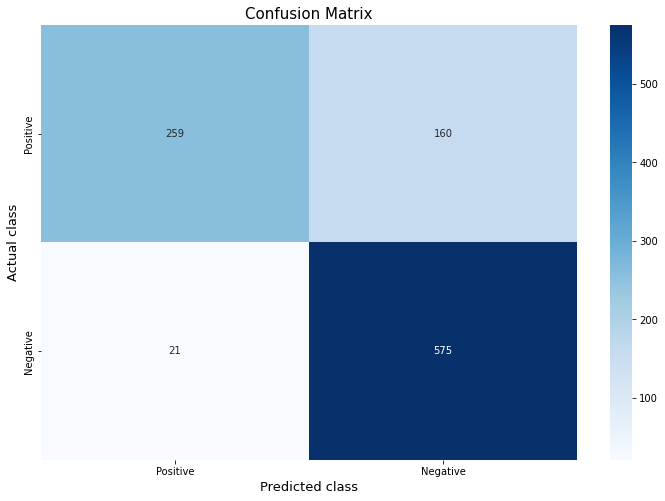

In [17]:
#Get the confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(label_arr, pred_arr).ravel()
cf_matrix = [[tp, fn], [fp, tn]]

fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(cf_matrix, 
            xticklabels=['Positive','Negative'], 
            yticklabels=['Positive','Negative'], 
            annot=True, fmt = 'd', cmap='Blues')

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual class', size = 13)
plt.xlabel('Predicted class', size = 13) 

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(label_arr == 1, output_arr[:, 1])
J = tpr - fpr # Youden’s J statistic
idx = np.argmax(J)
best_thresh = thresholds[idx]
roc_auc = metrics.auc(fpr, tpr)
sens, spec = tpr[idx], 1-fpr[idx]
print(f"ROCAUC:\t\t\t\t\t{roc_auc}")
print(f"Best threshold(Youden’s J statistic):\t{best_thresh}")
print(f"Sensitivity:\t\t\t\t{sens}")
print(f"Specificity:\t\t\t\t{spec}")

ROCAUC:					0.8692076051961366
Best threshold(Youden’s J statistic):	0.35056212544441223
Sensitivity:				0.7016706443914081
Specificity:				0.9211409395973155


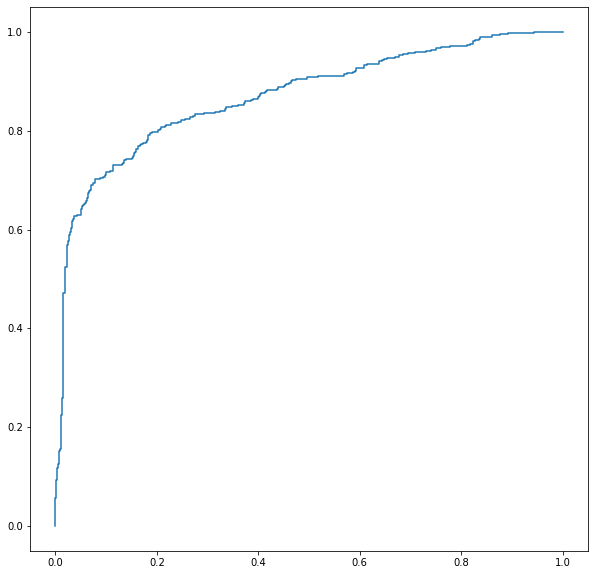

In [19]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)

## Grad-CAM

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [21]:
def inverse_normalization(img, mean_std, grayscale=False):
    tmp = []
    if grayscale:
        return img*mean_std[1][0] + mean_std[0][0]
        
    for l in range(3):
        tmp.append((img[:,:,l]*mean_std[1][l]) + mean_std[0][l])
        
    return np.stack(tmp, axis=-1)

In [28]:
test_dataset = MURADataset(
    data_dir=dataroot,
    csv_path=csvpath,  
    resize_factor=resize_factor,
    gray_scale=gray_scale,
    transform=get_transform,
    mode='Test', 
    convert=True
)
intest_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                            pin_memory=(torch.cuda.is_available()), num_workers=8)

In [65]:
test_model(features.cuda()).softmax(1)[0][1].cpu().data.item(), labels.cpu().data.item()

(0.07668514549732208, 0)

In [78]:
start_idx = 20
end_idx = 40

In [79]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category
    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]

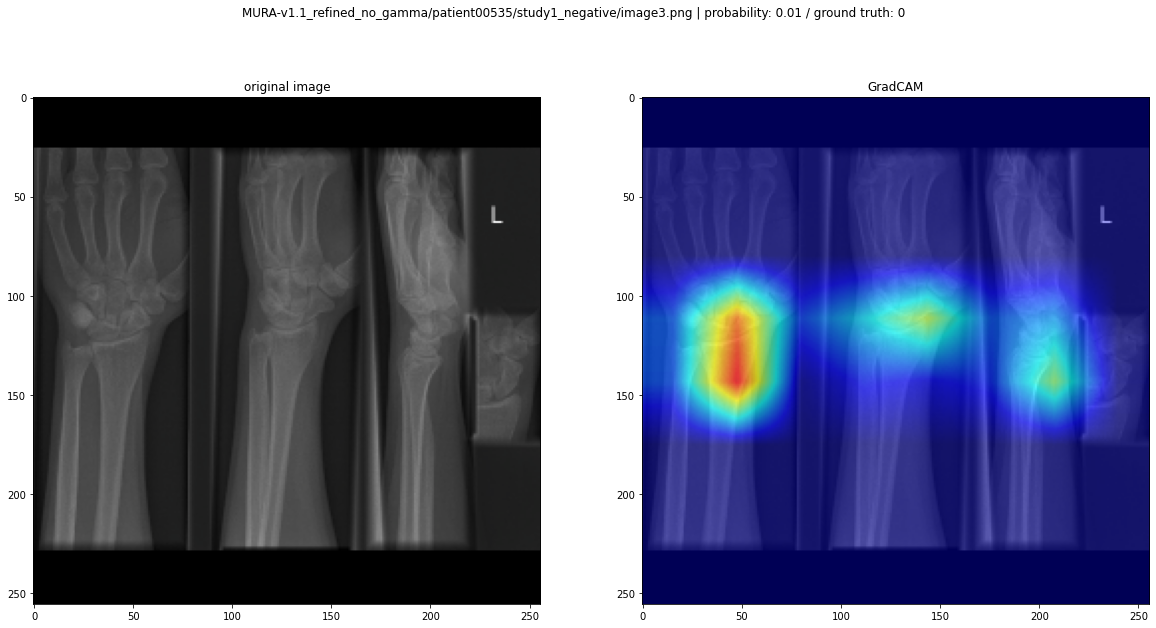

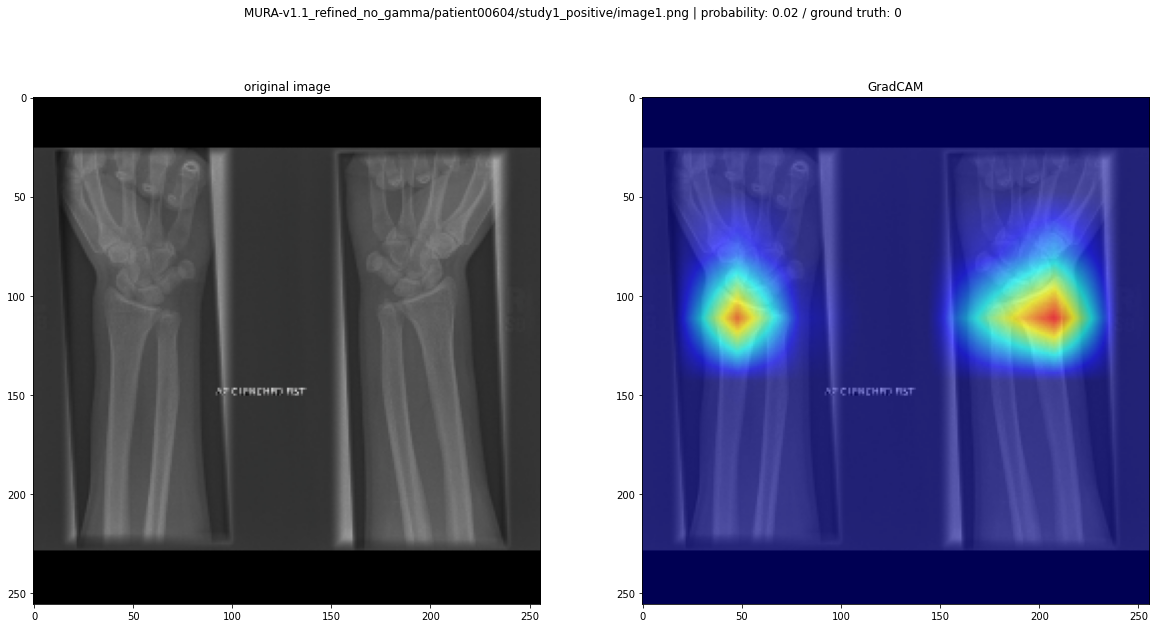

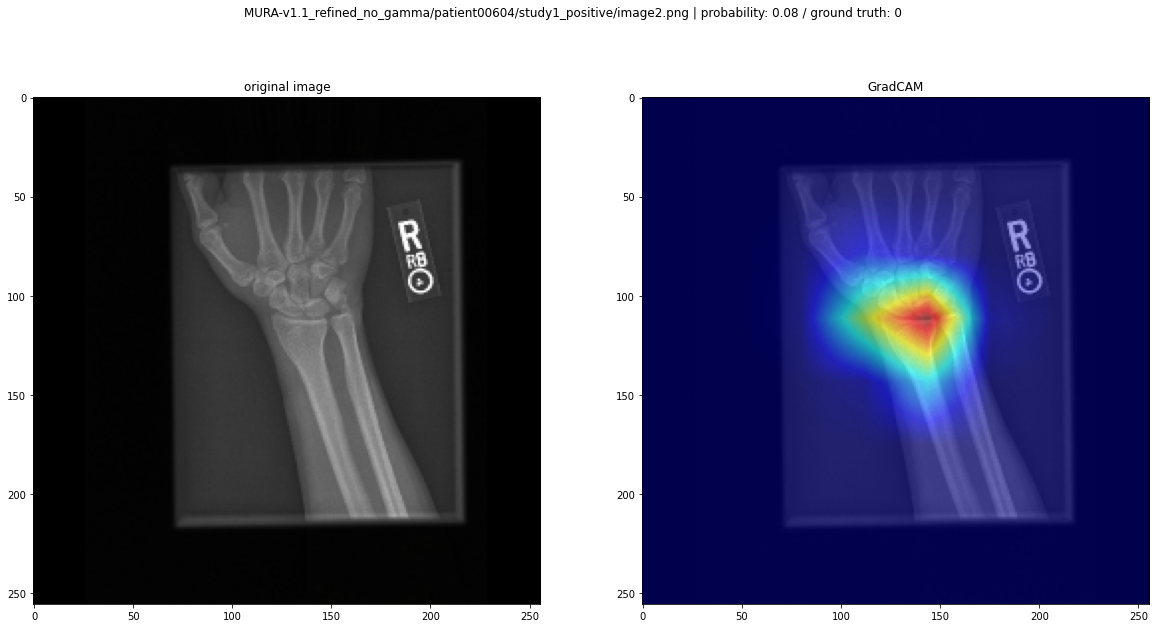

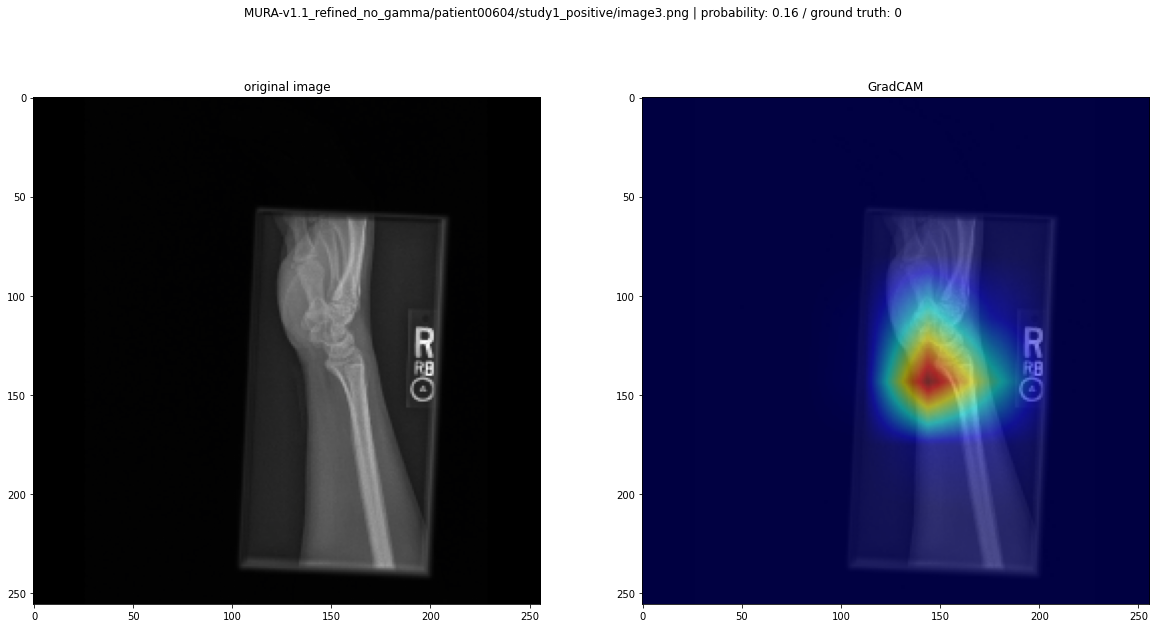

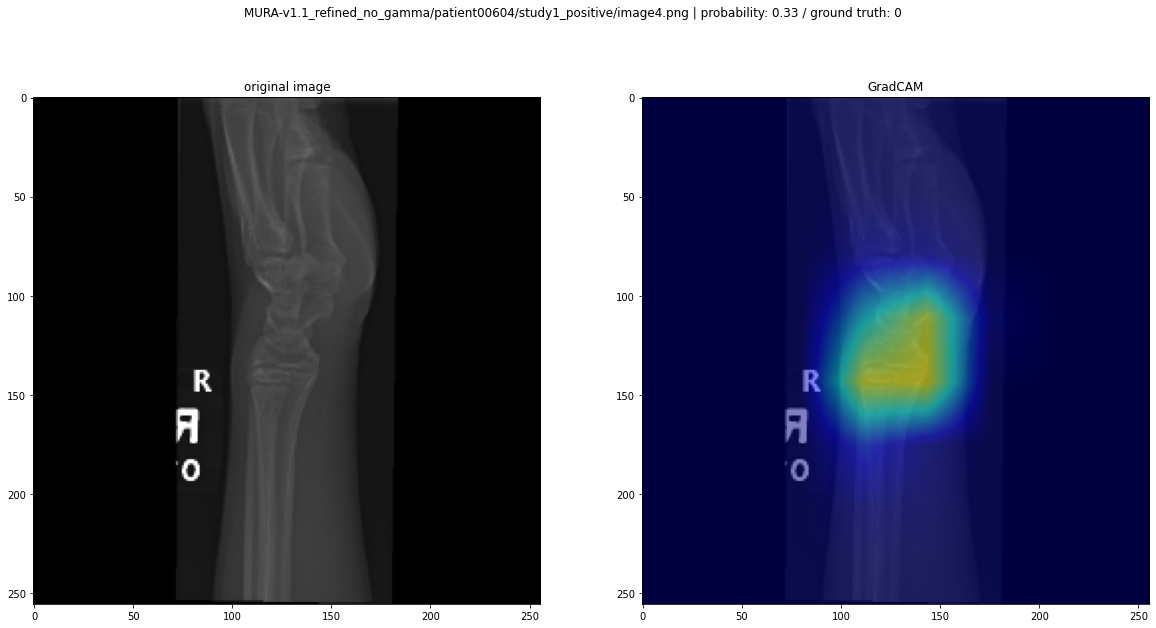

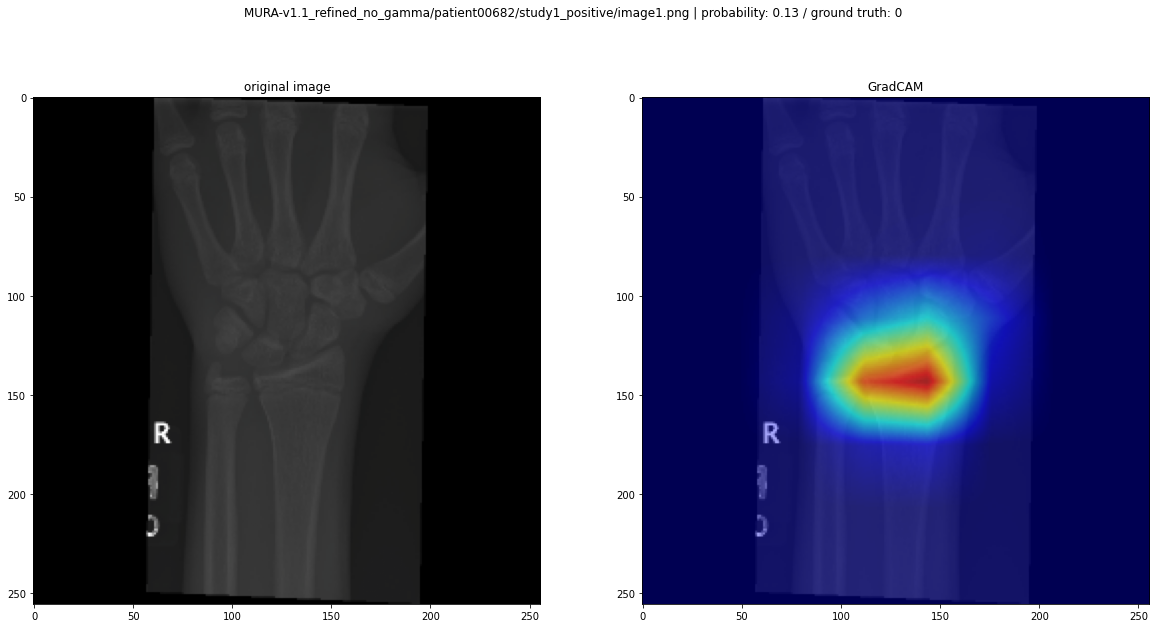

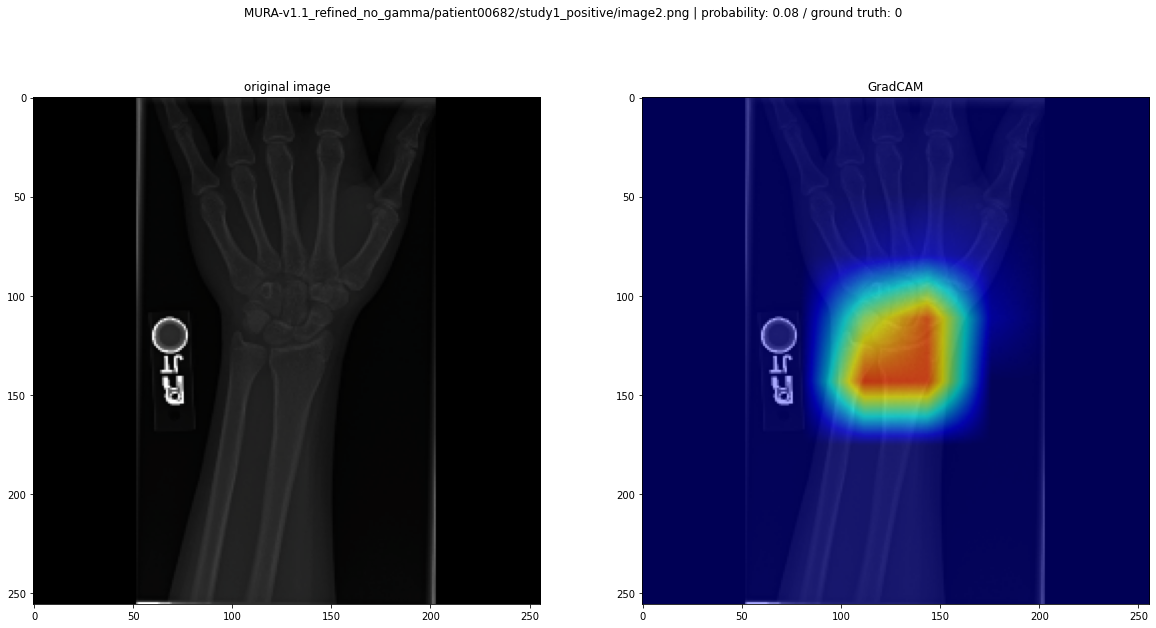

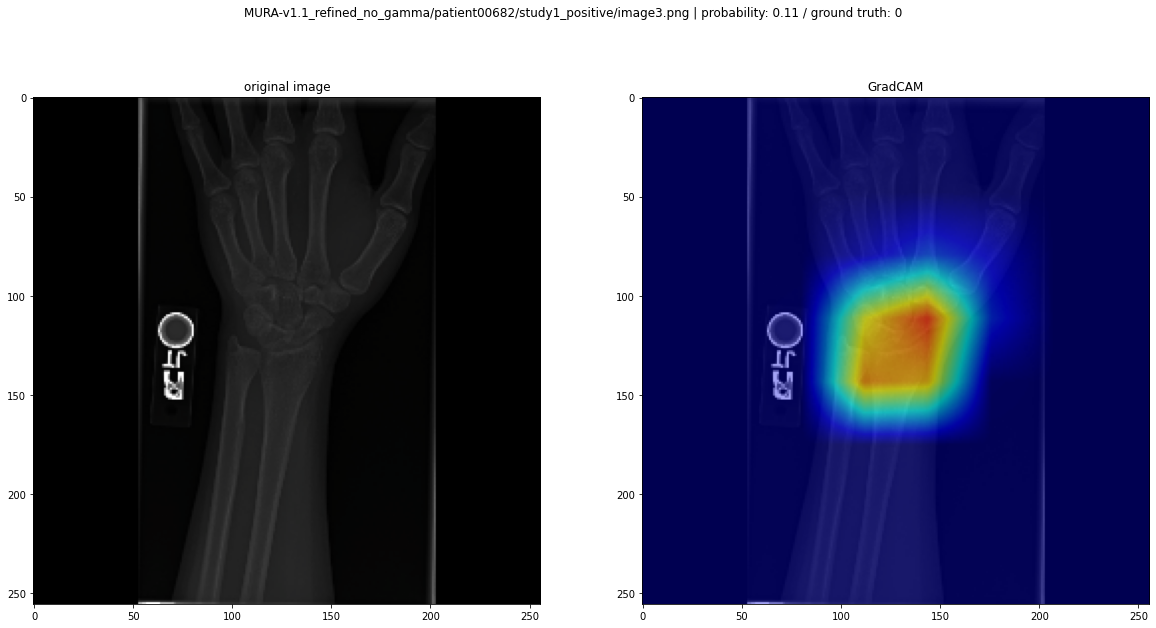

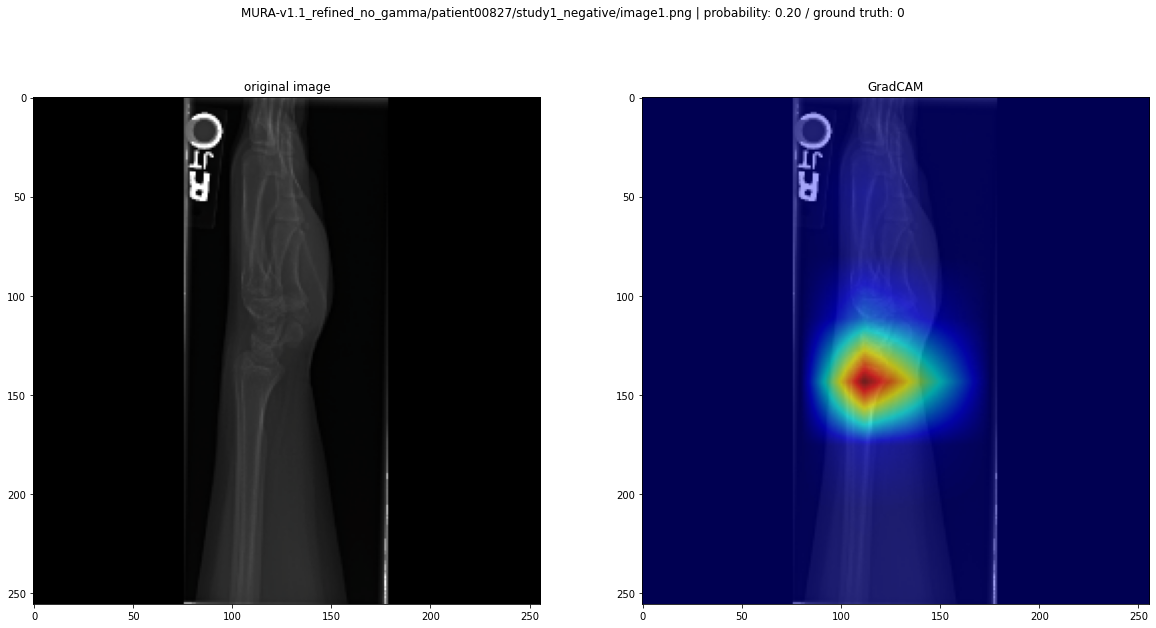

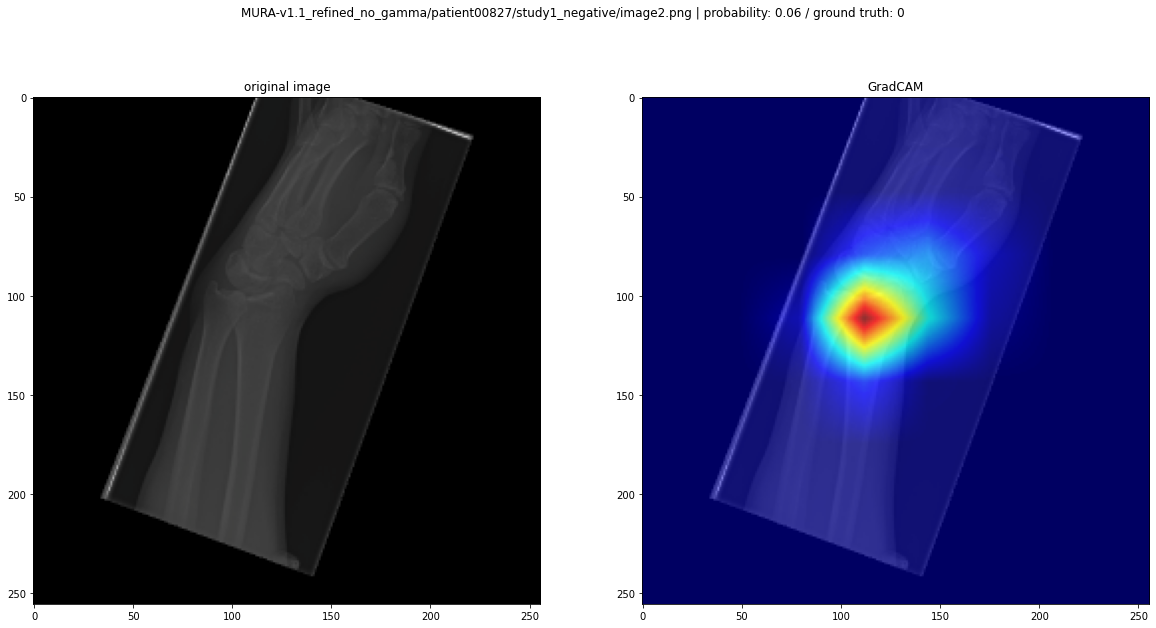

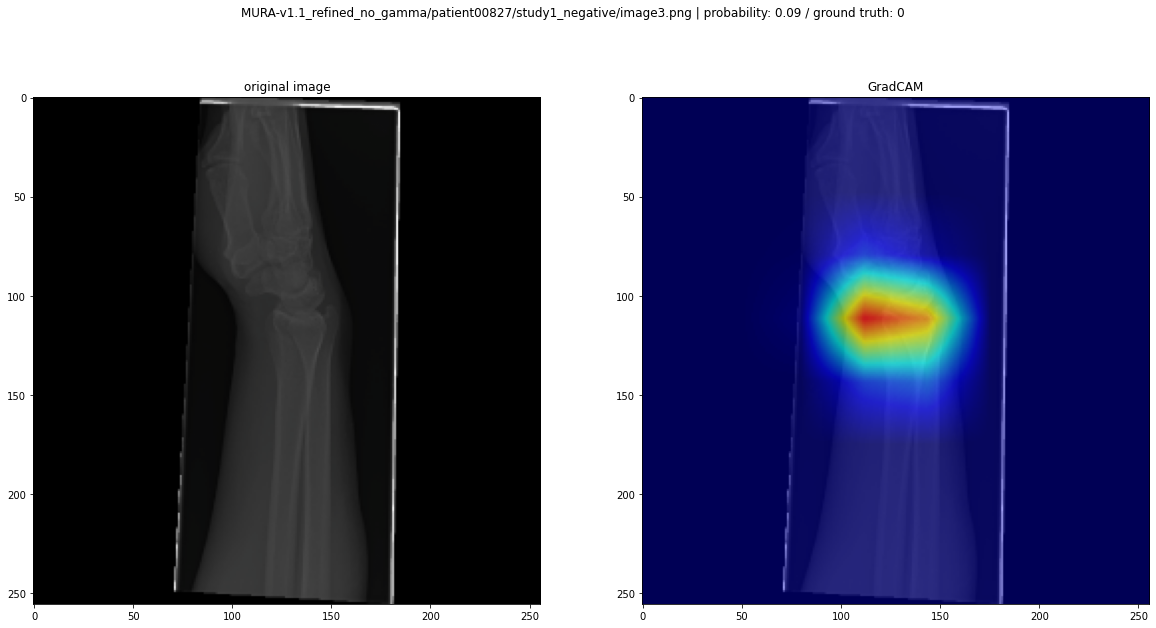

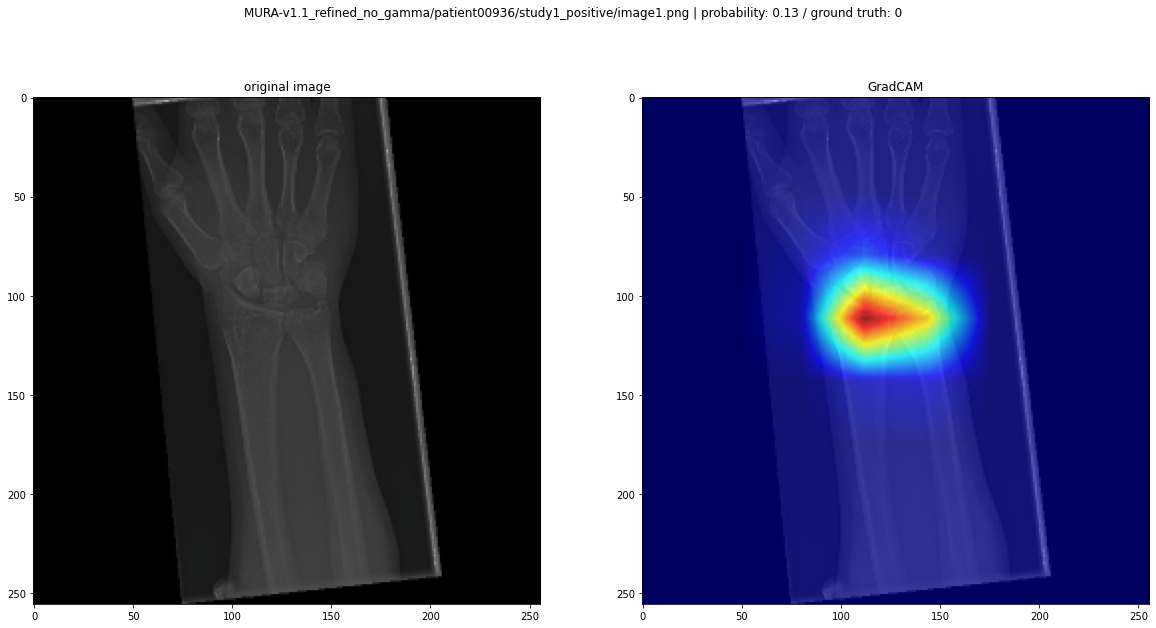

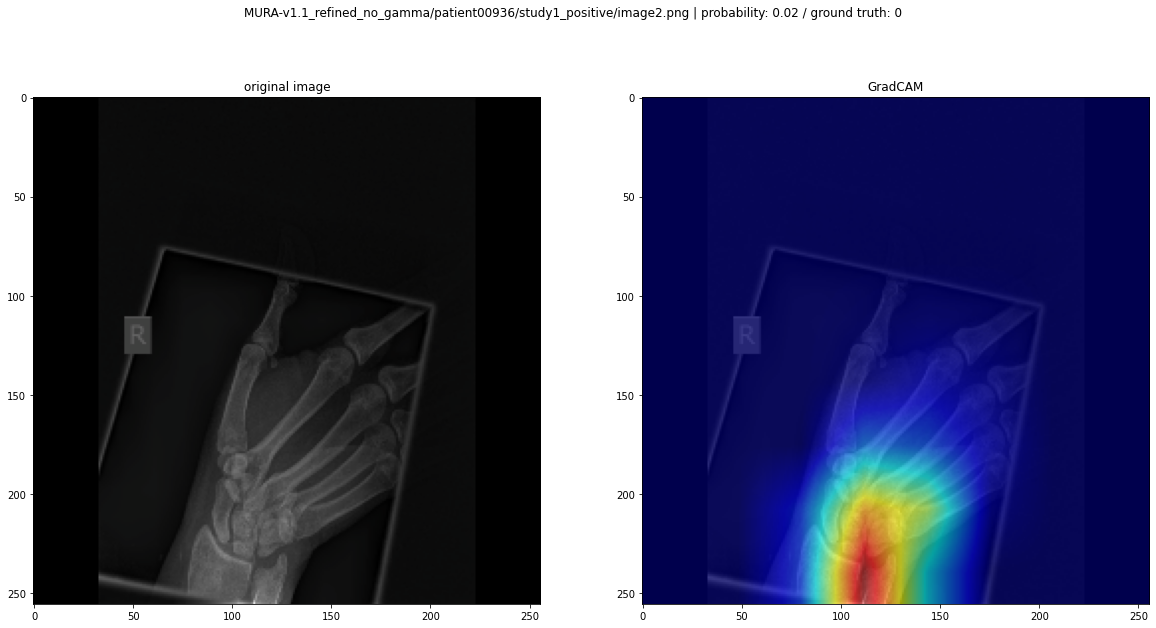

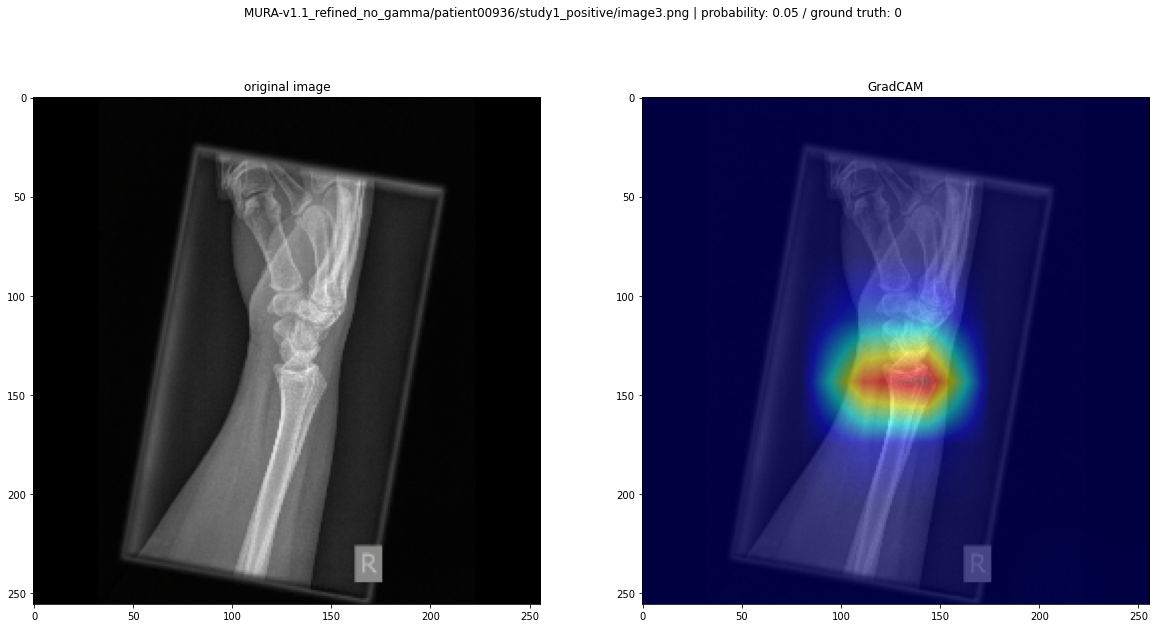

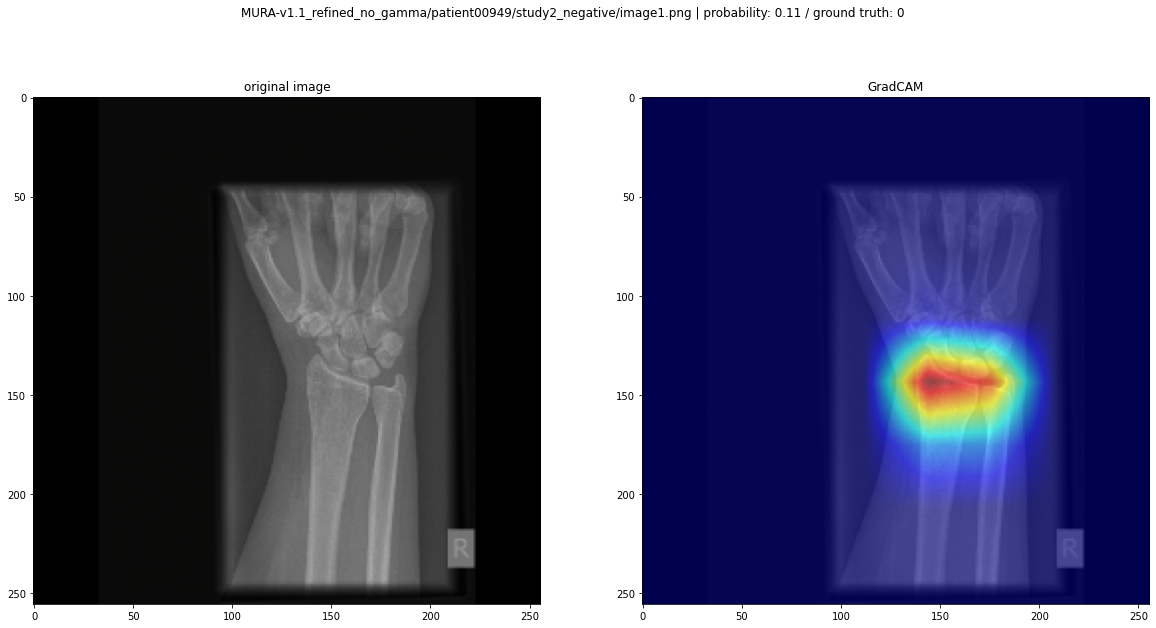

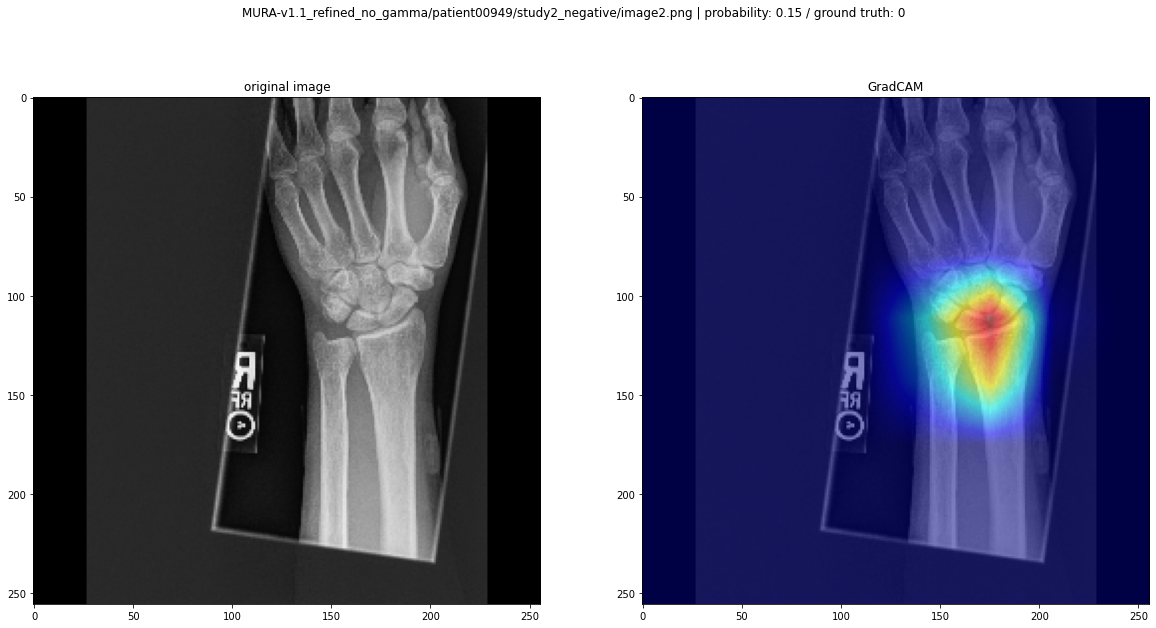

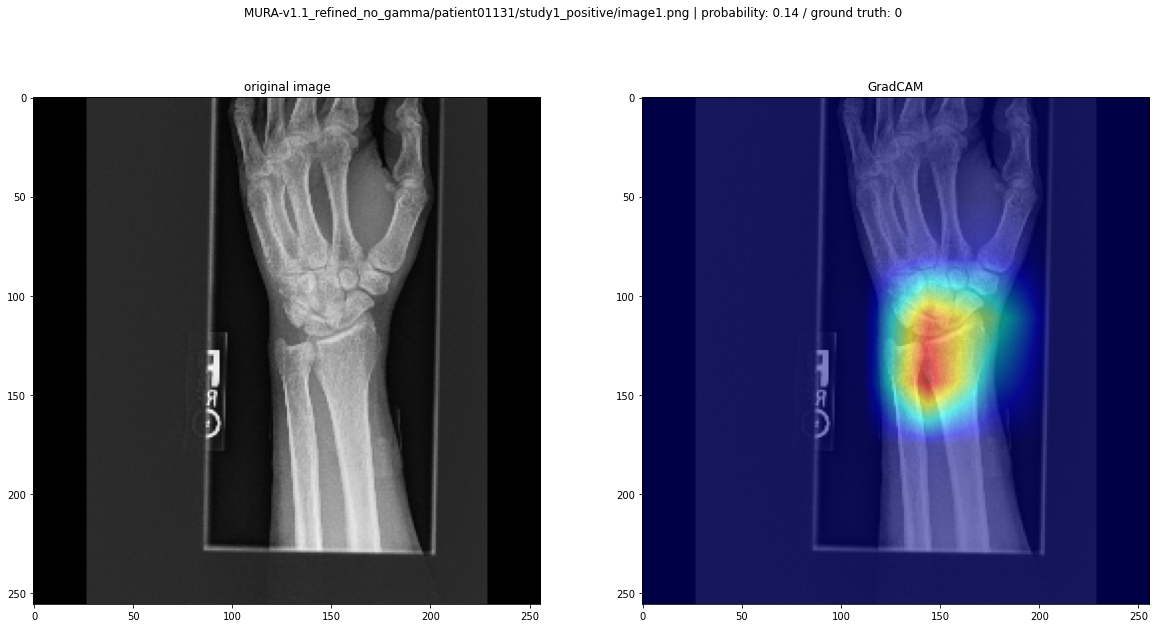

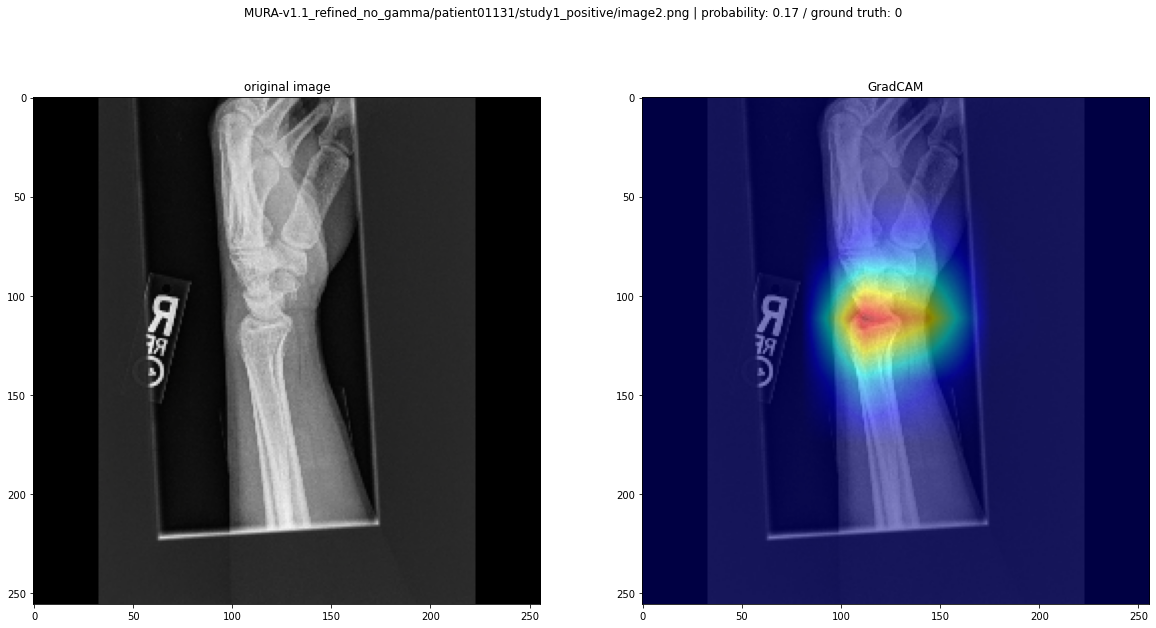

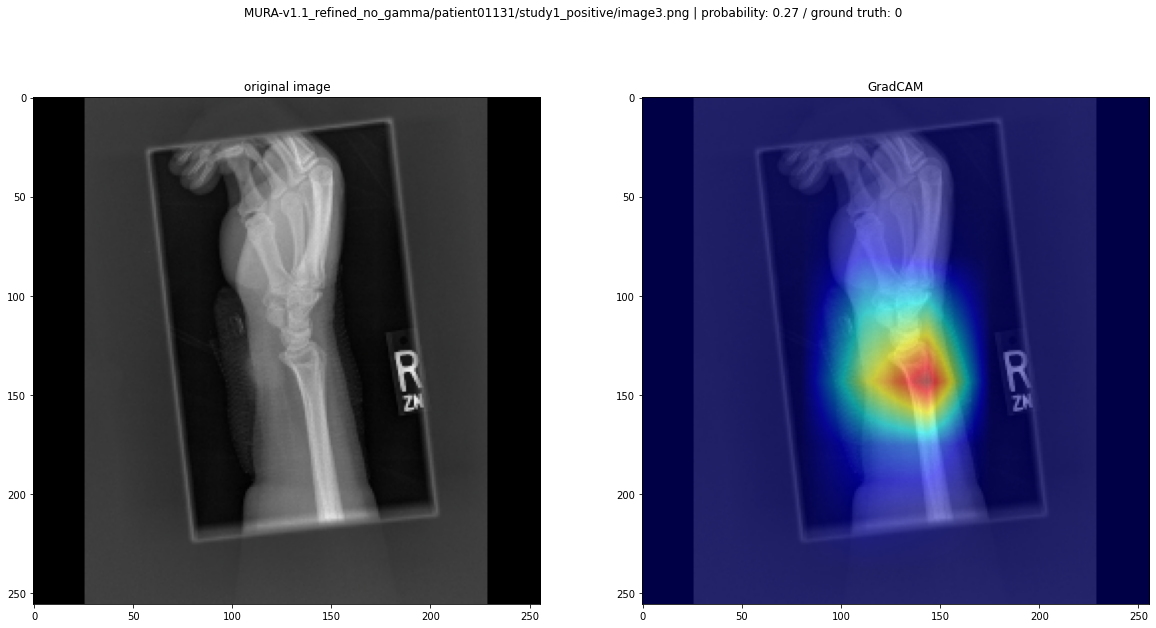

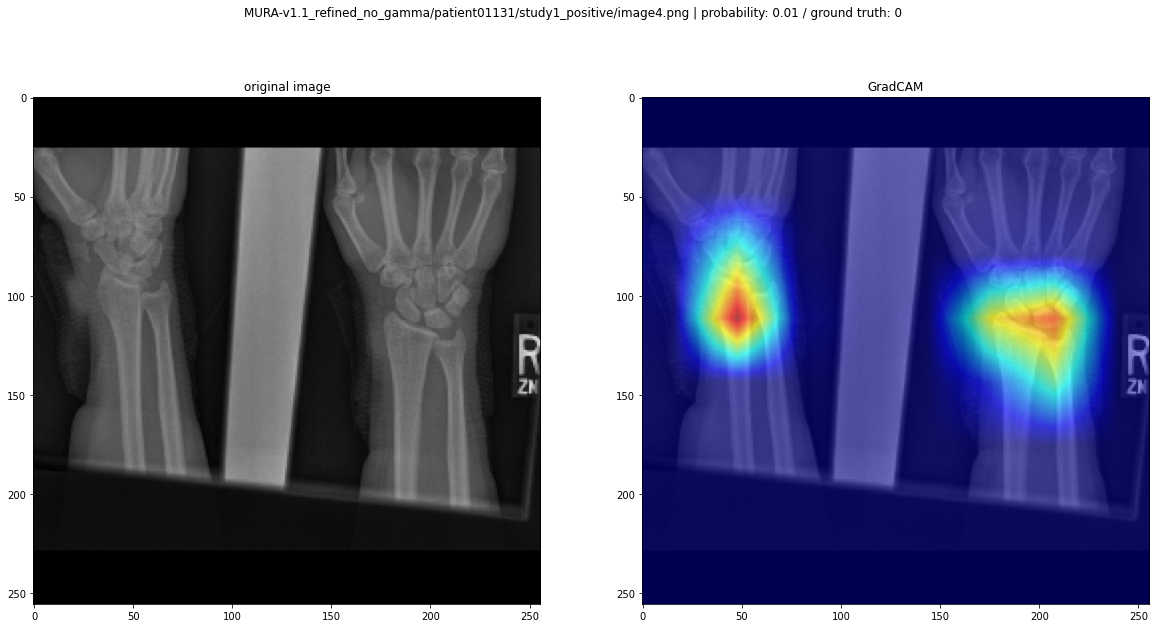

In [80]:
#target_layer = test_model.features.denseblock4.denselayer27
target_layer = [test_model.layer4[-1]]
#target_layer = test_model.layer4
cam = GradCAM(model=test_model, target_layers=target_layer, use_cuda=True)

dataiter = iter(intest_loader)

for i in range(start_idx, end_idx):
    data1 = dataiter.next()
    features, labels = data1
    inv_norm_feature = inverse_normalization(features[0].permute(1, 2, 0),[(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)], grayscale=False)

    grayscale_cam = cam(input_tensor=features, targets=[ClassifierOutputTarget(1)],aug_smooth=True,eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(inv_norm_feature, grayscale_cam, use_rgb=True)
    
    prob = test_model(features.cuda()).softmax(1)[0][1].cpu().data.item()
    label = labels.cpu().data.item()
    #print(test_model(features.cuda()).softmax(1)[0][1], labels)
    fig,ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(inv_norm_feature)
    ax[0].set_title(f'original image')
    ax[1].imshow(cam_image)
    ax[1].set_title('GradCAM')
    plt.suptitle(f'{test_dataset.data_path[i]} | probability: {prob:.2f} / ground truth: {label}')